## Importar librerías

In [1]:
from math import sqrt

from numpy import (array, unravel_index, nditer, linalg, random, subtract,
                   power, exp, pi, zeros, arange, outer, meshgrid, dot)
from collections import defaultdict
from warnings import warn


"""
    Minimalistic implementation of the Self Organizing Maps (SOM).
"""


def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.

    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return sqrt(dot(x, x.T))


class MiniSom(object):
    def __init__(self, x, y, input_len, sigma=2.0, sigma_final=1.0, 
                 learning_rate=0.5, learning_rate_final=0.05, decay_function=None, random_seed=None):
        """
            Initializes a Self Organizing Maps.
            x,y - dimensions of the SOM
            input_len - number of the elements of the vectors in input
            sigma - spread of the neighborhood function (Gaussian), needs to be adequate to the dimensions of the map.
            (at the iteration t we have sigma(t) = sigma / (1 + t/T) where T is #num_iteration/2)
            learning_rate - initial learning rate
            (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
            decay_function, function that reduces learning_rate and sigma at each iteration
                            default function: lambda x,current_iteration,max_iter: x/(1+current_iteration/max_iter)
            random_seed, random seed to use.
        """
        if sigma >= x/2.0 or sigma >= y/2.0:
            warn('Warning: sigma is too high for the dimension of the map.')
        if random_seed:
            self.random_generator = random.RandomState(random_seed)
        else:
            self.random_generator = random.RandomState(random_seed)
        if decay_function:
            self._decay_function = decay_function
        else:
            #self._decay_function = lambda x, t, max_iter: x/(1+t/max_iter)
            self._decay_function = lambda xi, xf, t, max_iter : xi*(xf/xi)**(t/max_iter)
        self.learning_rate = learning_rate
        self.learning_rate_final = learning_rate_final
        self.sigma = sigma
        self.sigma_final = sigma_final
        self.weights = self.random_generator.rand(x,y,input_len)*2-1 # random initialization
        for i in range(x):
            for j in range(y):
                self.weights[i,j] = self.weights[i,j] / fast_norm(self.weights[i,j]) # normalization
        self.activation_map = zeros((x,y))
        self.neigx = arange(x)
        self.neigy = arange(y) # used to evaluate the neighborhood function
        self.neighborhood = self.gaussian

    def _activate(self, x):
        """ Updates matrix activation_map, in this matrix the element i,j is the response of the neuron i,j to x """
        s = subtract(x, self.weights) # x - w
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.activation_map[it.multi_index] = fast_norm(s[it.multi_index])  # || x - w ||
            it.iternext()

    def activate(self, x):
        """ Returns the activation map to x """
        self._activate(x)
        return self.activation_map

    def gaussian(self, c, sigma):
        """ Returns a Gaussian centered in c """
        d = 2*pi*sigma*sigma
        ax = exp(-power(self.neigx-c[0], 2)/d)
        ay = exp(-power(self.neigy-c[1], 2)/d)
        return outer(ax, ay)  # the external product gives a matrix

    def diff_gaussian(self, c, sigma):
        """ Mexican hat centered in c (unused) """
        xx, yy = meshgrid(self.neigx, self.neigy)
        p = power(xx-c[0], 2) + power(yy-c[1], 2)
        d = 2*pi*sigma*sigma
        return exp(-p/d)*(1-2/d*p)

    def winner(self, x):
        """ Computes the coordinates of the winning neuron for the sample x """
        self._activate(x)
        return unravel_index(self.activation_map.argmin(), self.activation_map.shape)

    def update(self, x, win, t):
        """
            Updates the weights of the neurons.
            x - current pattern to learn
            win - position of the winning neuron for x (array or tuple).
            t - iteration index
        """
        # sigma and learning rate decrease with the same rule
        eta = self._decay_function(self.learning_rate, self.learning_rate_final, t, self.T)
        sig = self._decay_function(self.sigma, self.sigma_final, t, self.T) 
        g = self.neighborhood(win, sig)*eta # improves the performances
        it = nditer(g, flags=['multi_index'])
        while not it.finished:
            # eta * neighborhood_function * (x-w)
            self.weights[it.multi_index] += g[it.multi_index]*(x-self.weights[it.multi_index])
            # normalization
            self.weights[it.multi_index] = self.weights[it.multi_index] / fast_norm(self.weights[it.multi_index])
            it.iternext()

    def quantization(self, data):
        """ Assigns a code book (weights vector of the winning neuron) to each sample in data. """
        q = zeros(data.shape)
        for i, x in enumerate(data):
            q[i] = self.weights[self.winner(x)]
        return q

    def random_weights_init(self, data):
        """ Initializes the weights of the SOM picking random samples from data """
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] = data[self.random_generator.randint(len(data))]
            self.weights[it.multi_index] = self.weights[it.multi_index]/fast_norm(self.weights[it.multi_index])
            it.iternext()

    def train_random(self, data, num_iteration):
        """ Trains the SOM picking samples at random from data """
        self._init_T(num_iteration)
        for iteration in range(num_iteration):
            rand_i = self.random_generator.randint(len(data)) # pick a random sample
            self.update(data[rand_i], self.winner(data[rand_i]), iteration)

    def train_batch(self, data, num_iteration):
        """ Trains using all the vectors in data sequentially """
        self._init_T(len(data)*num_iteration)
        iteration = 0
        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx], self.winner(data[idx]), iteration)
            iteration += 1

    def _init_T(self, num_iteration):
        """ Initializes the parameter T needed to adjust the learning rate """
        self.T = num_iteration/2  # keeps the learning rate nearly constant for the last half of the iterations

    def distance_map(self):
        """ Returns the distance map of the weights.
            Each cell is the normalised sum of the distances between a neuron and its neighbours.
        """
        um = zeros((self.weights.shape[0], self.weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1, it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1, it.multi_index[1]+2):
                    if ii >= 0 and ii < self.weights.shape[0] and jj >= 0 and jj < self.weights.shape[1]:
                        um[it.multi_index] += fast_norm(self.weights[ii, jj, :]-self.weights[it.multi_index])
            it.iternext()
        um = um/um.max()
        return um

    def activation_response(self, data):
        """
            Returns a matrix where the element i,j is the number of times
            that the neuron i,j have been winner.
        """
        a = zeros((self.weights.shape[0], self.weights.shape[1]))
        for x in data:
            a[self.winner(x)] += 1
        return a

    def quantization_error(self, data):
        """
            Returns the quantization error computed as the average distance between
            each input sample and its best matching unit.
        """
        error = 0
        for x in data:
            error += fast_norm(x-self.weights[self.winner(x)])
        return error/len(data)

    def win_map(self, data):
        """
            Returns a dictionary wm where wm[(i,j)] is a list with all the patterns
            that have been mapped in the position i,j.
        """
        winmap = defaultdict(list)
        for x in data:
            winmap[self.winner(x)].append(x)
        return winmap

### unit tests
from numpy.testing import assert_almost_equal, assert_array_almost_equal, assert_array_equal


class TestMinisom:
    def setup_method(self, method):
        self.som = MiniSom(5, 5, 1)
        for i in range(5):
            for j in range(5):
                assert_almost_equal(1.0, linalg.norm(self.som.weights[i,j]))  # checking weights normalization
        self.som.weights = zeros((5, 5))  # fake weights
        self.som.weights[2, 3] = 5.0
        self.som.weights[1, 1] = 2.0

    def test_decay_function(self):
        assert self.som._decay_function(1., 2., 3.) == 1./(1.+2./3.)

    def test_fast_norm(self):
        assert fast_norm(array([1, 3])) == sqrt(1+9)

    def test_gaussian(self):
        bell = self.som.gaussian((2, 2), 1)
        assert bell.max() == 1.0
        assert bell.argmax() == 12  # unravel(12) = (2,2)

    def test_win_map(self):
        winners = self.som.win_map([5.0, 2.0])
        assert winners[(2, 3)][0] == 5.0
        assert winners[(1, 1)][0] == 2.0

    def test_activation_reponse(self):
        response = self.som.activation_response([5.0, 2.0])
        assert response[2, 3] == 1
        assert response[1, 1] == 1

    def test_activate(self):
        assert self.som.activate(5.0).argmin() == 13.0  # unravel(13) = (2,3)

    def test_quantization_error(self):
        self.som.quantization_error([5, 2]) == 0.0
        self.som.quantization_error([4, 1]) == 0.5

    def test_quantization(self):
        q = self.som.quantization(array([4, 2]))
        assert q[0] == 5.0
        assert q[1] == 2.0

    def test_random_seed(self):
        som1 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som2 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        assert_array_almost_equal(som1.weights, som2.weights)  # same initialization
        data = random.rand(100,2)
        som1 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som1.train_random(data,10)
        som2 = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        som2.train_random(data,10)
        assert_array_almost_equal(som1.weights,som2.weights)  # same state after training

    def test_train_batch(self):
        som = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        data = array([[4, 2], [3, 1]])
        q1 = som.quantization_error(data)
        som.train_batch(data, 10)
        assert q1 > som.quantization_error(data)

    def test_train_random(self):
        som = MiniSom(5, 5, 2, sigma=1.0, learning_rate=0.5, random_seed=1)
        data = array([[4, 2], [3, 1]])
        q1 = som.quantization_error(data)
        som.train_random(data, 10)
        assert q1 > som.quantization_error(data)

    def test_random_weights_init(self):
        som = MiniSom(2, 2, 2, random_seed=1)
        som.random_weights_init(array([[1.0, .0]]))
        for w in som.weights:
            assert_array_equal(w[0], array([1.0, .0]))


In [2]:
import numpy as np
import pickle
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pylab as plt
#from minisom import MiniSom

class KMedians(KMeans):
    def _e_step(self, X):
        self.labels_ = manhattan_distances(X, self.cluster_centers_).argmin(axis=1)
    def _average(self, X):
        return np.median(X, axis=0)

## Importar dataset


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dado que se trabaja desde colab, la direccion cambia

In [4]:
country_data = pickle.load(open("/content/drive/MyDrive/u/Colab Notebooks/New inteligence/t4/country_normalized_exports.pkl", "rb"))
country_data['feature_name'].insert(
    76, '(Reserved for possible future use in the Harmonized System.)')
world_data = country_data['world_data']
world_labels = country_data['world_labels']
world_labels_short = country_data['world_labels_short']
feature_names = country_data['feature_name']
N, M = world_data.shape
print("Nombres de paises y sus abreviaturas:")
I = np.argsort(world_labels_short)
print(np.concatenate((np.asarray(world_labels_short)[I, np.newaxis], 
                      np.asarray(world_labels)[I, np.newaxis]), axis=1))

Nombres de paises y sus abreviaturas:
[['abw' 'Aruba']
 ['afg' 'Afghanistan']
 ['ago' 'Angola']
 ['aia' 'Anguilla']
 ['alb' 'Albania']
 ['and' 'Andorra']
 ['are' 'United Arab Emirates']
 ['arg' 'Argentina']
 ['arm' 'Armenia']
 ['asm' 'American Samoa']
 ['atf' 'French Southern Territories']
 ['atg' 'Antigua and Barbuda']
 ['aus' 'Australia']
 ['aut' 'Austria']
 ['aze' 'Azerbaijan']
 ['bdi' 'Burundi']
 ['ben' 'Benin']
 ['bes' 'Caribbean Netherlands']
 ['bfa' 'Burkina Faso']
 ['bgd' 'Bangladesh']
 ['bgr' 'Bulgaria']
 ['bhr' 'Bahrain']
 ['bhs' 'Bahamas']
 ['bih' 'Bosnia and Herzegovina']
 ['blr' 'Belarus']
 ['blx' 'Belgium-Luxembourg']
 ['blz' 'Belize']
 ['bmu' 'Bermuda']
 ['bol' 'Bolivia, Plurinational State of']
 ['bra' 'Brazil']
 ['brb' 'Barbados']
 ['brn' 'Brunei Darussalam']
 ['btn' 'Bhutan']
 ['caf' 'Central African Republic']
 ['can' 'Canada']
 ['cck' 'Cocos (Keeling) Islands']
 ['che' 'Switzerland']
 ['chl' 'Chile']
 ['chn' 'China']
 ['civ' "Côte d'Ivoire"]
 ['cmr' 'Cameroon']
 ['c

## Agrupar exportaciones

In [5]:
grouped_data = np.zeros((len(world_data), 15))
indexes = [0, 5, 15, 24, 27, 38, 40, 43, 49, 63, 67, 71, 83, 85, 89, 97]
for i in range(15):
    start = indexes[i]
    end = indexes[i+1]
    grouped_data[:, i] = world_data[:, start:end].sum(axis=1)
grouped_feature_names = [
    'Animal & Animal Products',
    'Vegetable Products',
    'Foodstuffs',
    'Mineral Products',
    'Chemicals & Allied Industries',
    'Plastics / Rubbers',
    'Raw Hides, Skins, Leather & Furs',
    'Wood & Wood Products',
    'Textiles',
    'Footwear / Headgear',
    'Stone / Glass',
    'Metals',
    'Machinery / Electrical',
    'Transportation',
    'Miscellaneous'
]

## Seleccionar subconjunto de paises para etiquetas

In [6]:
countries_subset = ['are','arg','aus','aut','bgd',
    'bgr','bhr','blr','blx','bol','bra','caf','can',
    'chl','chn','civ','cmr','cod','cog','col','cub',
    'deu','dnk','ecu','egy','esp','fin','fra','gbr',
    'geo','gha','grc','hkg','hti','idn','ind','irl',
    'irn','irq','isr','ita','jpn','kwt','mex','nld',
    'nor','pak','per','pol','prk','prt','pry','pse',
    'qat','rus','sau','sgp','ury','usa','yem','zaf',
    'kaz','kor','idn','isl','sen','uzb','sur','flk',
    'grl','tun','cri','kna','eth','afg','uga'
]

## Activar/Desactivar agrupación de productos

Cambie el valor de la variable booleana is_grouped

In [7]:
is_grouped = True
if is_grouped:
    selected_data = grouped_data
    selected_features = grouped_feature_names
else:
    selected_data = world_data
    selected_features = feature_names
# Normalizar datos
world_data_scaled = scale(selected_data, axis=0, with_mean=True, with_std=True)

## Clustering usando kmedians

El parámetro n_clusters modifica el número de clusters

In [52]:
clustering = KMedians(n_clusters=15)
pred_labels = clustering.fit_predict(world_data_scaled)
print("Suma de errores cuadráticos: %f" %(clustering.inertia_))

Suma de errores cuadráticos: 992.890794


## Visualización con PCA

Varianza explicada por los primeros componentes principales:
[0.15481744 0.10809297 0.09129899 0.08445255 0.07320873 0.07005537
 0.06960979 0.06535666 0.05983643 0.05554138 0.05104628]
Suma acumulada de los primeros componentes principales: 0.883317


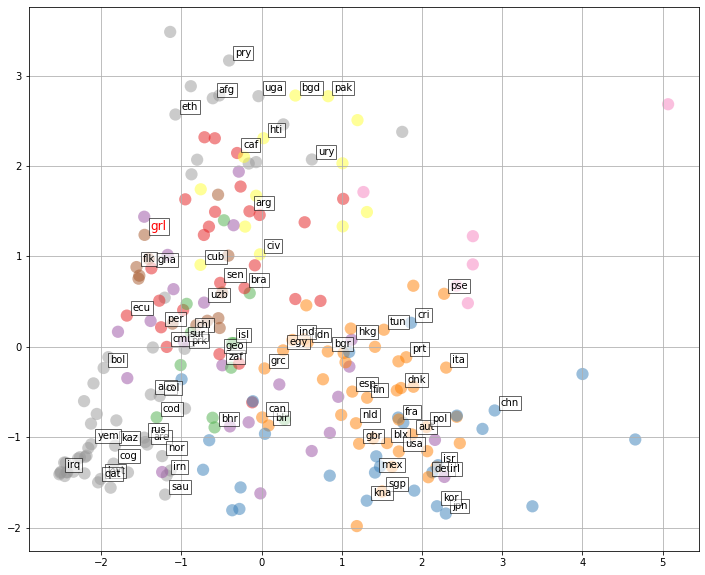

In [53]:
pca = PCA(n_components=11)
pca_no_kernel_projection = pca.fit_transform(world_data_scaled)
world_data_projected = pca_no_kernel_projection
print("Varianza explicada por los primeros componentes principales:")
print(pca.explained_variance_ratio_)
print("Suma acumulada de los primeros componentes principales: %f" % np.sum(pca.explained_variance_ratio_))
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(world_data_projected[:, 0], world_data_projected[:, 1], 
           c=pred_labels/clustering.n_clusters, linewidth=0, alpha=0.5, s=150, cmap='Set1')
xscale = world_data_projected[:, 0].max() - world_data_projected[:, 0].min()
yscale = world_data_projected[:, 1].max() - world_data_projected[:, 1].min()
for i in range(N):
    if world_labels_short[i] in countries_subset:
        if world_labels_short[i] == "grl":
            ax.annotate(world_labels_short[i], 
                        xy=(world_data_projected[i, 0]+0.01*xscale, world_data_projected[i, 1]+0.01*yscale), fontsize=12, color='r',
                       bbox={'facecolor':'white', 'alpha':0.6, 'pad':2})
        else:
            ax.annotate(world_labels_short[i], 
                        xy=(world_data_projected[i, 0]+0.01*xscale, world_data_projected[i, 1]+0.01*yscale), fontsize=10,
                       bbox={'facecolor':'white', 'alpha':0.6, 'pad':2})
plt.grid()

## Visualización con KernelPCA

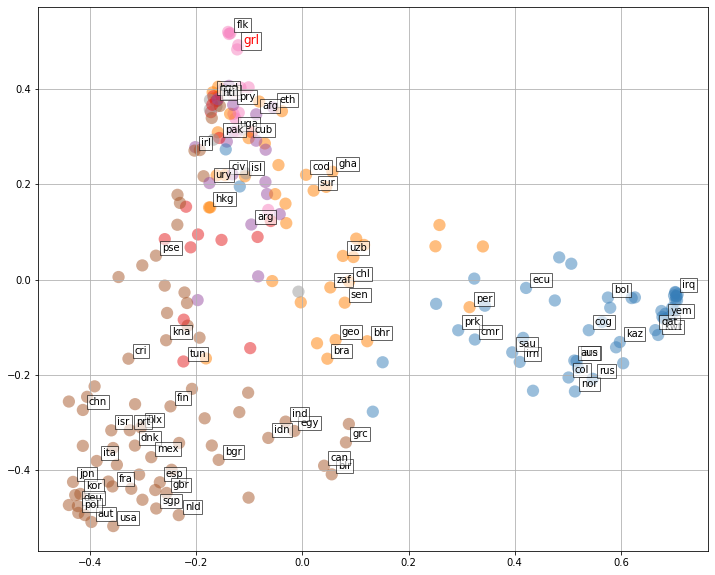

In [26]:
pca = KernelPCA(n_components=11, kernel="rbf")
pca_kernel_projection = pca.fit_transform(world_data_scaled) 
world_data_projected = pca_kernel_projection
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(world_data_projected[:, 0], world_data_projected[:, 1], 
           c=pred_labels/clustering.n_clusters, linewidth=0, alpha=0.5, s=150, cmap='Set1')
xscale = world_data_projected[:, 0].max() - world_data_projected[:, 0].min()
yscale = world_data_projected[:, 1].max() - world_data_projected[:, 1].min()
for i in range(N):
    if world_labels_short[i] in countries_subset:
        if world_labels_short[i] == "grl":
            ax.annotate(world_labels_short[i], 
                        xy=(world_data_projected[i, 0]+0.01*xscale, world_data_projected[i, 1]+0.01*yscale), fontsize=12, color='r',
                       bbox={'facecolor':'white', 'alpha':0.6, 'pad':2})
        else:
            ax.annotate(world_labels_short[i], 
                        xy=(world_data_projected[i, 0]+0.01*xscale, world_data_projected[i, 1]+0.01*yscale), fontsize=10,
                       bbox={'facecolor':'white', 'alpha':0.6, 'pad':2})
plt.grid()

## Visualización SOM sobre PCA

In [54]:
som_data = pca_no_kernel_projection # Componentes principales de PCA sin kernel
som_size = [30, 25]
sm = MiniSom(som_size[0], som_size[1], som_data.shape[1], 
             sigma=np.amax(som_size)/4, sigma_final=np.amax(som_size)/10,
             learning_rate=1.5, learning_rate_final=0.5)
print("Error de cuantización (inicial): %f" %(sm.quantization_error(som_data)))
# Ajuste grueso
sm.train_random(som_data, 2000)
print("Error de cuantización (ajuste grueso): %f" %(sm.quantization_error(som_data)))
# Ajuste fino
sm.sigma = np.amax(som_size)/10
sm.sigma_final = 1.5
sm.learning_rate = 0.5
sm.learning_rate_final = 0.1
sm.train_random(som_data, 2000)
print("Error de cuantización (ajuste fino): %f" %(sm.quantization_error(som_data)))

Error de cuantización (inicial): 2.637186
Error de cuantización (ajuste grueso): 2.460919
Error de cuantización (ajuste fino): 2.432820


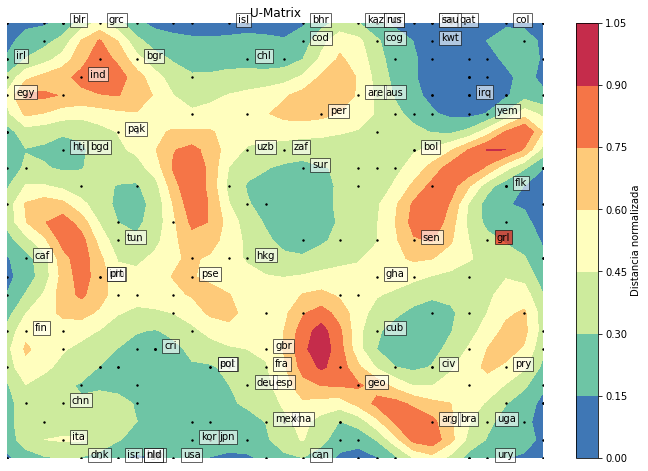

In [28]:
# U-Matrix
umat = sm.distance_map()
fig = plt.figure(figsize=(12, 8)) 
ax = fig.add_subplot(1, 1, 1)
cf = ax.contourf(umat.T, cmap=plt.cm.Spectral_r)
plt.colorbar(cf, label='Distancia normalizada')
plt.title('U-Matrix')
ax.axis('off')
for i in range(N):
    bmu = sm.winner(som_data[i, :])
    ax.scatter(bmu[0], bmu[1], s=2, c='k')
    if world_labels_short[i] in countries_subset:
        if world_labels_short[i] == "grl":
            ax.annotate(world_labels_short[i], xy=(bmu[0]+0.5, bmu[1]),
                   bbox={'facecolor':'red', 'alpha':0.6, 'pad':2})
        else:
            ax.annotate(world_labels_short[i], xy=(bmu[0]+0.5, bmu[1]),
                       bbox={'facecolor':'white', 'alpha':0.6, 'pad':2})

## Visualización SOM sobre Kernel PCA

In [55]:
som_kdata = pca_kernel_projection # Componentes principales de PCA con kernel
som_ksize = [30, 25]
ksm = MiniSom(som_ksize[0], som_ksize[1], som_kdata.shape[1], 
             sigma=np.amax(som_ksize)/4, sigma_final=np.amax(som_ksize)/10,
             learning_rate=1.5, learning_rate_final=0.5)
print("Error de cuantización (inicial): %f" %(ksm.quantization_error(som_kdata)))
# Ajuste grueso
ksm.train_random(som_kdata, 2000)
print("Error de cuantización (ajuste grueso): %f" %(ksm.quantization_error(som_kdata)))
# Ajuste fino
ksm.sigma = np.amax(som_ksize)/10
ksm.sigma_final = 1.5
ksm.learning_rate = 0.5
ksm.learning_rate_final = 0.1
ksm.train_random(som_kdata, 2000)
print("Error de cuantización (ajuste fino): %f" %(ksm.quantization_error(som_kdata)))

Error de cuantización (inicial): 0.645387
Error de cuantización (ajuste grueso): 0.435851
Error de cuantización (ajuste fino): 0.429719


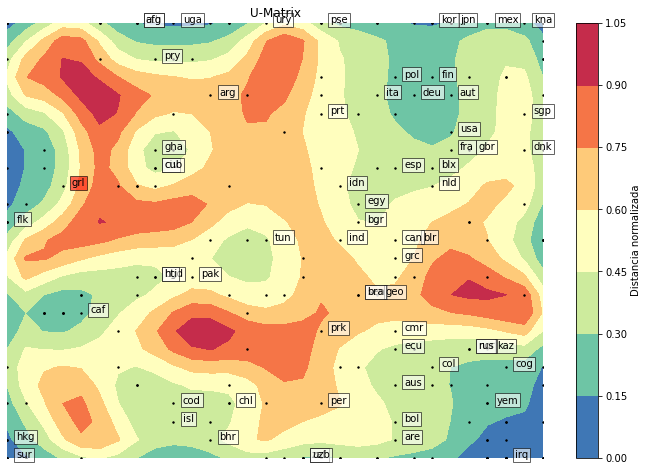

In [56]:
# U-Matrix
umat = ksm.distance_map()
fig = plt.figure(figsize=(12, 8)) 
ax = fig.add_subplot(1, 1, 1)
cf = ax.contourf(umat.T, cmap=plt.cm.Spectral_r)
plt.colorbar(cf, label='Distancia normalizada')
plt.title('U-Matrix')
ax.axis('off')
for i in range(N):
    bmu = ksm.winner(som_kdata[i, :])
    ax.scatter(bmu[0], bmu[1], s=2, c='k')
    if world_labels_short[i] in countries_subset:
        if world_labels_short[i] == "grl":
            ax.annotate(world_labels_short[i], xy=(bmu[0]+0.5, bmu[1]),
                   bbox={'facecolor':'red', 'alpha':0.6, 'pad':2})
        else:
            ax.annotate(world_labels_short[i], xy=(bmu[0]+0.5, bmu[1]),
                       bbox={'facecolor':'white', 'alpha':0.6, 'pad':2})

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


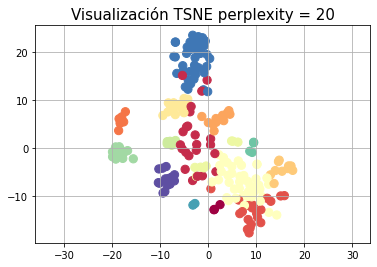

In [93]:
from sklearn.manifold import TSNE
p=20
t_sne = TSNE(n_components=2, perplexity=p, learning_rate=100, random_state=419)
X = t_sne.fit_transform(world_data_scaled)

plt.scatter(X[:, 0], X[:, 1],c=pred_labels/clustering.n_clusters,cmap='Spectral', s=68)
plt.gca().set_aspect('equal', 'datalim')
plt.title(f'Visualización TSNE perplexity = {p}', fontsize=15);
xscale = X[:, 0].max() - X[:, 0].min()
yscale = X[:, 1].max() - X[:, 1].min()
for i in range(N):
    if world_labels_short[i] in countries_subset:
        if world_labels_short[i] == "chl":
            ax.annotate(world_labels_short[i], 
                        xy=(X[:, 0]+0.01*xscale, X[:, 1]+0.01*yscale), fontsize=12, color='r',
                       bbox={'facecolor':'white', 'alpha':100, 'pad':2})
        else:
            ax.annotate(world_labels_short[i], 
                        xy=(X[:, 0]+0.01*xscale, X[:, 1]+0.01*yscale), fontsize=10,
                       bbox={'facecolor':'white', 'alpha':0.6, 'pad':2})
plt.grid()